In [1]:
from keras.models import model_from_json
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import *

Using TensorFlow backend.


In [2]:
model = Sequential()

model.add(InputLayer(input_shape=[64,64,3]))
model.add(Conv2D(filters = 32, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=5, padding='same'))

model.add(Conv2D(filters = 50, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=5, padding='same'))

model.add(Conv2D(filters = 80, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=5, padding='same'))

model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation = 'softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [3]:
model.load_weights("model2.h5")

In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 50)        40050     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 50)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 80)          100080    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 1, 1, 80)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 1, 80)          0         
__________

In [5]:
import cv2
from os.path import isfile
file1 = "cell_image4.jpg"
print("Yes" if isfile(file1) else "No")

Yes


In [6]:
params = cv2.SimpleBlobDetector_Params()
params.minThreshold = 10
params.maxThreshold = 255
params.filterByArea = True
params.minArea = 1000
params.filterByCircularity = True
params.minCircularity = 0.01
params.filterByConvexity = True
params.minConvexity = 0.01
params.filterByInertia = True
params.minInertiaRatio = 0.01

In [7]:
detector = cv2.SimpleBlobDetector_create(params)


In [8]:
import numpy as np
im = cv2.imread(file1)
im = cv2.blur(im,(10,10))
keypoints = detector.detect(im)
im_with_keypoints = cv2.drawKeypoints(im, keypoints,np.array([]), (0, 0, 255),
                                      cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

In [9]:
import matplotlib.pyplot as plt
print(len(keypoints))
plt.imshow(im_with_keypoints)
plt.title("Blobs identified")
plt.xticks([])
plt.yticks([])
plt.show()

21


<Figure size 640x480 with 1 Axes>

In [10]:
height,width = im.shape[0],im.shape[1]
mask = np.zeros((height,width), np.uint8)
for i in keypoints:
    # print(i.pt)
    # print(i.size)
    cv2.circle(mask, (int(i.pt[0]),int(i.pt[1])), int(i.size/2), (255, 255, 255), thickness=-1)
masked_data = cv2.bitwise_and(im, im, mask=mask)
# Apply Threshold
_,thresh = cv2.threshold(mask,1,255,cv2.THRESH_BINARY)

# Find Contour
contours = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[0]

rects = [cv2.boundingRect(ctr) for ctr in contours]

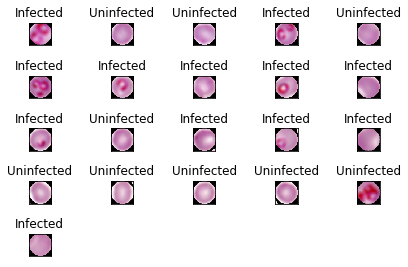

In [13]:
l = 0
count=0
i=1
for rect in rects:
    leng = int(rect[3])
    pt1 = int(rect[1] + rect[3] // 2 - leng // 2)
    pt2 = int(rect[0] + rect[2] // 2 - leng // 2)
    roi = masked_data[pt1:pt1 + leng, pt2:pt2 + leng]
    
    if roi.any():
        l+=1
        # Resize the image
        roi = cv2.resize(roi, (64,64), interpolation=cv2.INTER_AREA)
        result = model.predict(roi.reshape(1,64,64,3))
        label = "Uninfected" if np.argmax(result[0])==1 else "Infected"
        if label=="Infected":
            count+=1
        plt.subplot(5,5, i)
        plt.tight_layout()
        plt.imshow(roi)
        plt.title(label)
        plt.xticks([])
        plt.yticks([])
        i+=1
plt.show()
        

In [40]:
print("Total={0}\nInfected={1}\nUninfected={2}\n".format(l,count,l-count))

Total=21
Infected=12
Uninfected=9

